In [1]:
from utils import *
from Model_gpu import ProtoRNN
from itertools import combinations
from itertools import chain as ch
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

import matplotlib as mpl
from numpy.linalg import norm
from scipy.linalg import fractional_matrix_power
from scipy.stats import ttest_rel, ttest_1samp, sem
import scipy.io as io
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split
from einops import rearrange, repeat
import seaborn as sns
import numpy as np
import torch

e:\Anaconda\envs\fam\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

device(type='cuda')

In [3]:
# image param
num_kernel = 64
num_row = 8
num_col = 8

# simulation param
tau_stim = 150
delta_t = 1 
save_every_stim = 75

# init model
f = ProtoRNN(num_kernel, num_row, num_col, tau_stim, delta_t, save_every_stim)

# set wrp and theta [Optional]
# wrp = np.load(r'E:\Dataset\Lee\Circuits_noise_v3//weight_epoch4_tx25_100ms_20_10x10_64_8_8_mix50%_v3.npy')
# f.wrp = wrp

# move to deivice
f.to(device)

ProtoRNN()

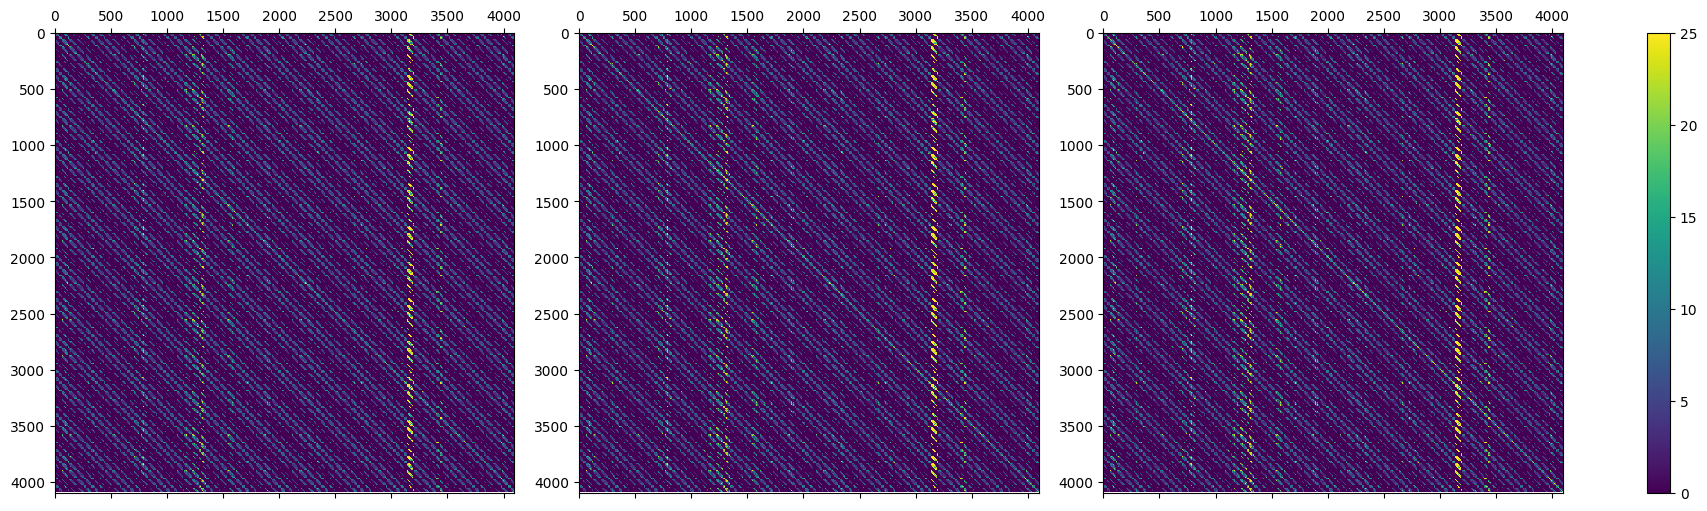

In [95]:
# wrp3 = np.load('Circuits_noise/weight_epoch3_multi10_200ms_2000_64_8_8_.npy')
wrp2 = np.load('SMT-BCM_weights_tempsup/weight_epoch2_tx25_300ms_5_4x10_64_8_8_mix50%_rep1_2e9pos1e7.npy')
wrp1 = np.load('SMT-BCM_weights_tempsup/weight_epoch1_tx25_300ms_5_4x10_64_8_8_mix50%_rep1_2e9pos1e7.npy')
wrp0 = np.load('SMT-BCM_weights_tempsup/weight_epoch0_tx25_300ms_5_4x10_64_8_8_mix50%_rep1_2e9pos1e7.npy')
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(17, 5))
axs = axs.flatten()
# axs[0].matshow(f.wrp0.cpu().numpy() * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
axs[0].matshow(wrp0 * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
axs[1].matshow(wrp1 * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
pcm = axs[2].matshow(wrp2 * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
# pcm = axs[3].matshow(wrp2 * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
# pcm = axs[4].matshow(wrp3 * f.N_neighbors, vmax=f.wrp_max * f.N_neighbors)
plt.colorbar(pcm, ax=axs)

#### Simulation

In [4]:
# get feedforward input
mix_coef = 2
r_in = np.load('E:/Dataset/Lee/SMT-BCM_input_correct/r_in_cifar_all_noise_abs_5_4_10_64_8_8.npy')
r_in, t_ind, n_ind = insertTeachingSig(r_in, p=mix_coef)
r_in = torch.tensor(r_in).reshape(-1, 1, f.num_kernel, f.num_row, f.num_col).float().to(device)
r_in.shape
# # select anchor points
# anchor = np.arange(0, 50, 5)
# r_in = ff[:, anchor, :, :, :]  # (num_stim, 10, num_kernel, num_row, num_col) scale: 10%, 20% ... 100%

torch.Size([300, 1, 64, 8, 8])

In [6]:
# set simulation param
n_trials = 1
f.noise_test = 0

In [6]:
ys_test_all = []
# for i in trange(n_trials, desc='trials...', position=0):
for i in range(n_trials):
    ys_test = f.test(r_in, 0)
    ys_test_all.append(ys_test)

ys_test_all = np.stack(ys_test_all).squeeze()
ys_test_all.shape

testing...: 100%|██████████| 540000/540000 [09:42<00:00, 927.34it/s]


(3600, 76, 8192)

In [7]:
# save
np.save('Response_noise_tempsup/r_pre_rx1_150ms_mean_20_10x10_75_64_8_8_mix50%_v3.npy', ys_test_all)

#### BCM threshold based on ys

In [5]:
ys_test_all = np.load('SMT-BCM_response_correct/r_pre_rx1_150ms_mean_5_4x10_15_64_8_8_train_mix50%_all.npy')
ys_test_all = seqUnmix(ys_test_all, t_ind, n_ind, n_imgs=5, npa=10)  # 500, 11, Ne+Ni
ys_test_all.shape
# plt.plot(np.sort(ys_test_all[:, -1, :f.N_e], axis=0)[::-1].mean(-1), label='after')

(200, 16, 8192)

In [14]:
# random threshold
theta_BCM = 1e-2 + 1e-2 * np.random.rand(4096)

/tmp/ipykernel_32468/808696275.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(high_r)


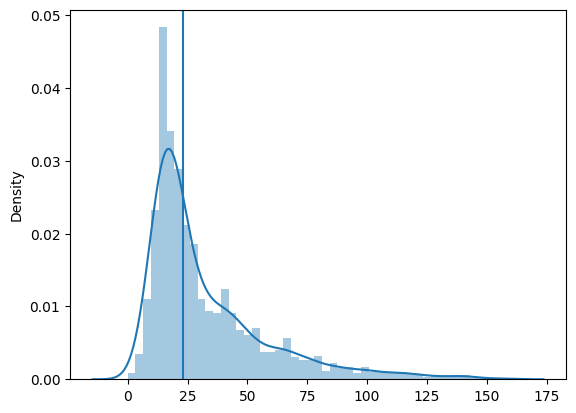

In [28]:
# obtaining BCM threshold based on mean (eliminate noise and trial=1)
ys_exc = f.r_numpy(ys_test_all[:, :, :f.N_e])
theta_BCM = (ys_exc**2).mean((0, 1))
# check BCM threshold (for each neuron only 5% of stimuli will be above the threshold)
ys_exc_eq = ys_exc[:, -2:].mean(1)
r_in_sorted = np.sort(ys_exc_eq, 0)[::-1]
high_r = np.sum(r_in_sorted > theta_BCM, axis=0)
sns.distplot(high_r)
plt.axvline(np.median(high_r))

In [29]:
np.save('SMT-BCM_input_correct/BCM_theta_cifar_all_noise_abs_5_4_10_64_8_8.npy', theta_BCM)

#### Attractor state dimensionality reduction

For different nl trained together

In [5]:
ys_pre = np.load('E:/Dataset/Lee/SMT-BCM_response_correct/r_pre_rx1_1000ms_mean_5_4x10_50_64_8_8_mix50%_all.npy') 
ys_pre = seqUnmix(ys_pre, t_ind, n_ind, n_imgs=5, npa=10)[..., :f.N_e]  # n_img*nl*np, 5, Ne
ys_pre = f.r_numpy(ys_pre)[:, -2:].mean(-2)

# ts = np.arange(0, 76, 5)
# ys_pre = ys_pre[:, ts]

ys_all = [ys_pre]
del ys_pre
for i in range(5):
    ys_e = np.load(f'E:/Dataset/Lee/SMT-BCM_response_correct/r_epoch{i}_tx30_rx1_1000ms_mean_5_4x10_50_64_8_8_mix50%_2e9pos1e7_all.npy') 
    ys_e = seqUnmix(ys_e, t_ind, n_ind, n_imgs=5, npa=10)[..., :f.N_e]  # n_img*nl*np, 5, Ne
    ys_e = f.r_numpy(ys_e)[:, -2:].mean(-2)
    # ys_e = ys_e[:, ts]
    ys_all.append(ys_e)
    del ys_e

ys_all_exc = np.stack(ys_all)  # (day, n_img*nl*np, Ne)

In [6]:
ff_o = np.load('E:/Dataset/Lee/SMT-BCM_input_correct/r_in_cifar_all_noise_abs_5_4_10_64_8_8.npy')
ff_o = rearrange(ff_o, 'n l p d h w -> (n l p) (d h w)')  # n_img*nl*np, Ne

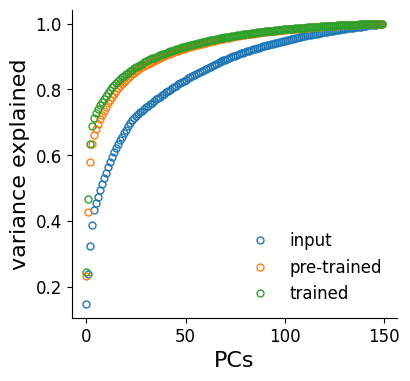

In [14]:
n_pc = 200
pca = PCA(n_components=n_pc)
pca.fit(ff_o)
pcd = [np.cumsum(pca.explained_variance_ratio_)]

for n, d in enumerate([0, 5]):
    pca = PCA(n_components=n_pc)
    pca.fit(ys_all_exc[d])
    pcd.append(np.cumsum(pca.explained_variance_ratio_))

labels = ['input', 'pre-trained', 'trained']
for d, ds_ in enumerate(pcd):
    plt.plot(ds_[:150], 'o', markersize=5, mfc='none', label=f'{labels[d]}')
    # plt.axvline(x=50, color='black', linestyle='dashed')
    # plt.axvline(x=8, color='black', linestyle='dashed')
    
plt.legend(frameon=False)

fig = plt.gcf()
fig.set_size_inches(4.2, 4)

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylabel('variance explained')
ax.set_xlabel('PCs')
plt.savefig('PC_vars.png')

In [15]:
# PCA for calculating distance / visualize
n_pc = 200
pca = PCA(n_components=n_pc)

# ys_all_exc = np.concatenate([ff, ys_all_exc], 2)  # day, n_img*nl*np, 1+11, Ne
ys_all_inp = ys_all_exc.reshape(-1, f.N_e)  # (6x2000x5, f.N_e)

X_all = pca.fit_transform(ys_all_inp)
# X_all = X_all.reshape(6, 5, 4, 10, -1, n_pc)  # day, image, noise_level, noise_pattern, time, all_pc
X_all = X_all.reshape(6, 5, 4, 10, n_pc)  # day, image, noise_level, noise_pattern, all_pc

ff_r = pca.fit_transform(ff_o)
ff = ff_r.reshape(5, 4, 10, n_pc)  # image, noise_level, noise_pattern, all_pc

ff = ff[..., :n_pc]  # take first n pc
X = X_all[..., :n_pc]  # take first 25 pc

In [16]:
# MDS for visualize
n_d = 2
emb = MDS(n_components=n_d, normalized_stress='auto')

X_vs = []
for i in range(6):
    ys_all_inp = ys_all_exc[i]  # (200, f.N_e)
    X_v = emb.fit_transform(ys_all_inp.astype(np.float64))
    X_v = X_v.reshape(5, 4, 10, n_d)
    X_vs.append(X_v)

ff_v = emb.fit_transform(ff_o.astype(np.float64))
ff_v = ff_v.reshape(5, 4, 10, n_d)

In [23]:
# MDS for visualize
n_d = 2
emb = MDS(n_components=n_d, normalized_stress='auto')

ys_all_inp = np.concatenate([np.expand_dims(ff_o, 0), ys_all_exc], 0)  # 7, 200, Ne

X_v_all = emb.fit_transform(ys_all_inp.reshape(-1, f.N_e).astype(np.float64))
X_v_all = X_v_all.reshape(7, 5, 4, 10, n_d)

e:\Anaconda\envs\fam\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


#### Traj

In [63]:
ys_e = np.load(f'E:/Dataset/Lee/SMT-BCM_response_correct/r_epoch4_tx30_rx1_500ms_mean_5_4x10_250_64_8_8_mix50%_2e9pos1e7_all.npy') 
ys_e = seqUnmix(ys_e, t_ind, n_ind, n_imgs=5, npa=10)[..., :f.N_e]  # n_img*nl*np, 5, Ne
ys_e = f.r_numpy(ys_e)  # n_img*nl*np, 251, Ne

n_pc = 3
pca = PCA(n_components=n_pc)
traj_r = pca.fit_transform(ys_e.reshape(-1, f.N_e))
traj_r = traj_r.reshape(5, 4, 10, 251, -1)

io.savemat('score_model.mat', {'img1': traj_r.mean(2)})

In [62]:
ni = 1
traj = traj_r[ni].mean(1)  # 4, 251, 3
io.savemat('score_model.mat', {'img1': traj})

# nl = traj.shape[0]
# ax = plt.figure().add_subplot(111)
# # ax.view_init(elev=15, azim=150, roll=30)
# labels = ['clear', '10%', '30%', '50%']
# for i, traj_ in enumerate(traj):
#     ax.plot(*traj_.T, '-', color=plt.cm.gray(i/(nl+1)), linewidth=1, label=labels[i])
#     ax.scatter(*traj_[0].T, s=49, marker='^', color=plt.cm.gray(i/(nl+1)))
#     ax.scatter(*traj_[-1].T, s=49, marker='x', color=plt.cm.gray(i/(nl+1)))
    
#     ax.grid(False)
#     # ax.xaxis.pane.fill = False
#     # ax.yaxis.pane.fill = False
#     # ax.zaxis.pane.fill = False
# ax.legend(frameon=False)
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_yticks([-2, -1.5, -1, -0.5, 0], [-2, -1.5, -1, -0.5, 0])

# fig = plt.gcf()
# fig.set_size_inches(5.3, 4.2)

#### Attractor landscape

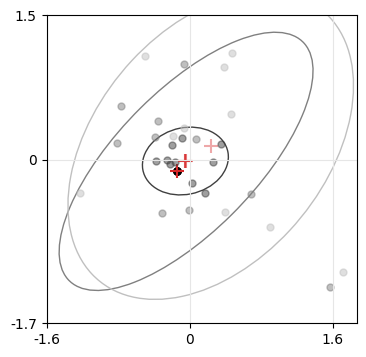

In [42]:
# noise cone
X_v = X_vs[-1].mean(0)  # 4, 10, 3
X_v_mean = X_v.mean(1)  # 4, 3
# cols = np.repeat(np.arange(4), 10)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

for i in range(4):
    X_vi = X_v[i]
    ax.scatter(*X_vi.T, color=plt.cm.gray(i/4), s=25, alpha=.5)
    cov = np.cov(X_vi, rowvar=False)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell_novel = Ellipse(xy=(X_vi.mean(0)[0], X_vi.mean(0)[1]), 
                        width=lambda_[0]*2*2, height=lambda_[1]*2*2, angle=np.rad2deg(np.arccos(v[0, 0])),
                        ec=plt.cm.gray(i/4), fc='none')
    ax.add_artist(ell_novel)
    ax.scatter(*X_v_mean[i], marker='+', s=100, color='tab:red', alpha=1-0.2*i)

# ax.set_ylim((-7, 7))
# ax.set_xlim((-7, 7))

ax.grid(color='0.9')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')

ax.set_yticks([-1.7, 0, 1.5], [-1.7, 0, 1.5])
ax.set_xticks([-1.6, 0, 1.6], [-1.6, 0, 1.6])
# ax.set_zlabel('PC3')

plt.savefig('noise_cone.png')

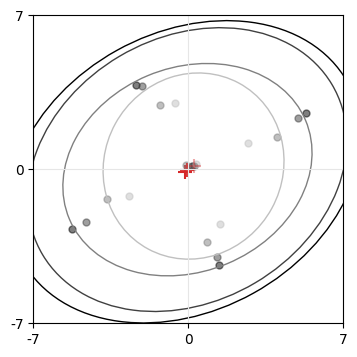

In [44]:
# image cone
X_v = X_vs[-1].mean(-2)  # 5, 4, 3
X_v_mean = X_v.mean(0)  # 4, 3
# cols = np.repeat(np.arange(4), 10)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

for i in range(4):
    X_vi = X_v[:, i]
    ax.scatter(*X_vi.T, color=plt.cm.gray(i/4), s=25, alpha=.5)
    cov = np.cov(X_vi, rowvar=False)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell_novel = Ellipse(xy=(X_vi.mean(0)[0], X_vi.mean(0)[1]), 
                        width=lambda_[0]*2*2, height=lambda_[1]*2*2, angle=np.rad2deg(np.arccos(v[0, 0])),
                        ec=plt.cm.gray(i/4), fc='none')
    ax.add_artist(ell_novel)
    ax.scatter(*X_v_mean[i], marker='+', s=100, color='tab:red', alpha=1-0.2*i)

# ax.set_ylim((-7, 7))
# ax.set_xlim((-7, 7))

ax.grid(color='0.9')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')

ax.set_yticks([-7, 0, 7], [-7, 0, 7])
ax.set_xticks([-7, 0, 7], [-7, 0, 7])
# ax.set_zlabel('PC3')

Text(0.5, 1.0, 'input')

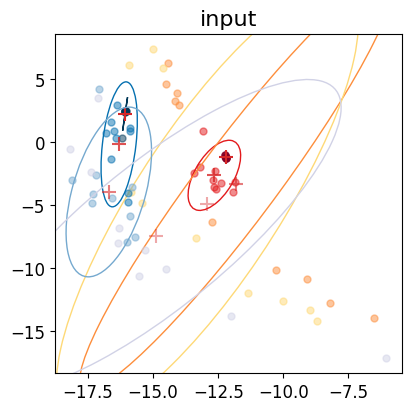

In [21]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 4))
# ax = fig.add_subplot(111)

cmap = [plt.cm.YlOrRd_r, plt.cm.PuBu_r]
for m, ni in enumerate([2, 4]):
    X_v_ = X_v_all[0, ni]  # 4, 10, nd
    X_v_mean = X_v_.mean(-2)  # 4, nd
    for j in range(4):
        X_vi = X_v_[j]  # 10, nd
        ax.scatter(*X_vi.T, color=cmap[m](j/4), s=25, alpha=.5)
        cov = np.cov(X_vi, rowvar=False)
        lambda_, v = np.linalg.eig(cov)
        lambda_ = np.sqrt(lambda_)
        ell_novel = Ellipse(xy=(X_vi.mean(0)[0], X_vi.mean(0)[1]), 
                            width=lambda_[0]*2*2, height=lambda_[1]*2*2, angle=np.rad2deg(np.arccos(v[0, 0])),
                            ec=cmap[m](j/4), fc='none')
        ax.add_artist(ell_novel)
        ax.scatter(*X_v_mean[j], marker='+', s=100, color='tab:red', alpha=1-0.2*j)
        # ax.grid(color='0.9')
ax.set_title(f'input')

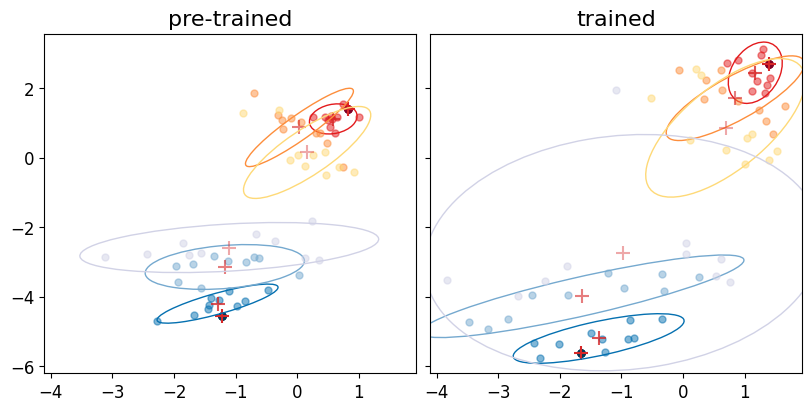

In [24]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4), sharex=True, sharey=True)
# ax = fig.add_subplot(111)

labels = ['pre-trained', 'trained']
cmap = [plt.cm.YlOrRd_r, plt.cm.PuBu_r]
for n, i in enumerate([1, 6]):
    ax = axs[n]
    for m, ni in enumerate([2, 4]):
        X_v_ = X_v_all[i, ni]  # 4, 10, nd
        X_v_mean = X_v_.mean(-2)  # 4, nd
        for j in range(4):
            X_vi = X_v_[j]  # 10, nd
            ax.scatter(*X_vi.T, color=cmap[m](j/4), s=25, alpha=.5)
            cov = np.cov(X_vi, rowvar=False)
            lambda_, v = np.linalg.eig(cov)
            lambda_ = np.sqrt(lambda_)
            ell_novel = Ellipse(xy=(X_vi.mean(0)[0], X_vi.mean(0)[1]), 
                                width=lambda_[0]*2*2, height=lambda_[1]*2*2, angle=np.rad2deg(np.arccos(v[0, 0])),
                                ec=cmap[m](j/4), fc='none')
            ax.add_artist(ell_novel)
            ax.scatter(*X_v_mean[j], marker='+', s=100, color='tab:red', alpha=1-0.2*j)
            # ax.grid(color='0.9')
    ax.set_title(f'{labels[n]}')

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(fp2.shape[2]):
    fp_allI_2D = fp3[[0, -1], :, i]  # day, imgs, noise_pattern, pc
    alphas = np.linspace(1, 0.5, fp_allI_2D.shape[0])
    for j in range(fp_allI_2D.shape[0]):
        for k in range(fp_allI_2D.shape[1]):
            ax.scatter(*fp_allI_2D[j, k].mean(0), color=colorFader(c1,c2,i/fp2.shape[2]), alpha=alphas[j], s=10)

c3 = 'black'
c4 = 'lightgray'
# backbone for ax3
fp3_2D = fp3[[0]]
for i in range(fp3_2D.shape[0]):
    for j in range(fp3_2D.shape[1]):
        ax.plot(*fp3_2D[i, j].mean(1).T, color=colorFader(c3,c4,i/fp3_2D.shape[0]))

fp3_2D = fp3[[0, -1]]
# first day to last day arrow for ax3
for i in range(fp3_2D.shape[1]):
    for j in range(fp3_2D.shape[2]):
        disp1 = fp3_2D[-1, i, j].mean(0) - fp3_2D[0, i, j].mean(0)  # noise_level, pc
        q1 = np.concatenate([fp3_2D[0, i, j].mean(0), disp1], -1)
        ax.quiver(*q1, color = colorFader(c1,c2,j/10), alpha = .8, lw = 1)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.grid(False)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

#### Attractor similarity

In [25]:
ff = ff.transpose(1, 0, 2, 3)  # noise_level, img, noise_pattern, pc
target_ff = ff[0].mean(axis=(0, 1)).reshape(1, 1, -1)  # 1, 1, pc
v_ff = ff.mean(-2)  # noise_level, img, pc
# v_ff = ff[:, :, 1]
dis_ff = v_ff - target_ff  # noise_level, img, pc
ref_ff = dis_ff[[0]]  # 1, img, pc

# fp = X[:, :, :, :, -2:, :].mean(-2)  # day, img, noise_level, noise_pattern, pc
fp = X
fp = fp.transpose(0, 2, 1, 3, 4)  # day, noise_level, img, noise_pattern, pc
day_num, nl, img, npt, _ = fp.shape

target = fp[:, 0].mean(axis=(1, 2)).reshape(day_num, 1, 1, -1)  # day, 1, 1, pc
# target = fp[0, 0].mean(axis=(0, 1)).reshape(1, 1, 1, -1)
v = fp.mean(-2)  # day, nl, img, pc
# v = fp[:, :, :, 1]  # day, noise_level, img, pc
dis = v - target  # day, nl, img, pc
# dis = v
ref = dis[:, [0]]  # day, 1, img, pc

# don't mean or sample nl, mean nl after calculate the matrices
# ff = ff.transpose(1, 0, 2, 3)  # noise_level, img, noise_pattern, pc
# target_ff = ff[0].mean(axis=(0, 1)).reshape(1, 1, 1, -1)  # 1, 1, 1, pc
# dis_ff = ff - target_ff  # nl, img, np, pc
# # dis_ff = ff
# ref_ff = dis_ff[[0]]  # 1, img, np, pc

# fp = X.transpose(0, 2, 1, 3, 4)  # day, nl, img, np, pc
# day_num, nl, img, npt, _ = fp.shape
# target = fp[:, 0].mean(axis=(1, 2)).reshape(day_num, 1, 1, 1, -1)  # day, 1, 1, 1, pc
# # target = fp[0, 0].mean(axis=(0, 1)).reshape(1, 1, 1, 1, -1)
# dis = fp - target  # day, nl, img, np, pc
# # dis = v
# ref = dis[:, [0]]  # day, 1, img, np, pc

Cosine similarity 

In [26]:
# for different nl trained together
cosine_dist = np.sum(dis*ref, axis=-1)/(norm(dis, axis=-1)*norm(ref, axis=-1))  # day, nl, np, img
cosine_dist_ff = np.sum(dis_ff*ref_ff, axis=-1)/(norm(dis_ff, axis=-1)*norm(ref_ff, axis=-1))  # nl, np, img
# cosine_dist = cosine_dist.mean(-2)  # day, nl, img
# cosine_dist_ff = cosine_dist_ff.mean(-2)  # nl, img

Euclidian distance

In [27]:
# for different nl trained together
euc_dist = norm(dis - ref, axis=-1)  # day, nl, img
euc_dist_ff = norm(dis_ff - ref_ff, axis=-1)  # nl, img

Effective distance

In [28]:
def cross_img_normalization(dis, ref):
    """
    cross-img normalisation of the euclidian distance between noise vector and its image counterpart

    params: dis: displacement vector from target point to the attractor. ndarray of shape (nl, img, pc)
    params: ref: reference vector for all the displacement vector. ndarray of shape (1, img, pc)
    return: normalized distance. ndarray of shape (nl, img)
    """
    day, nl, img, pc = dis.shape
    dis = dis.reshape(day, nl, img, 1, pc)  # nl, img, 1, pc
    ref = ref.reshape(day, 1, 1, img, pc)  # 1, 1, img, pc
    dist = norm(dis - ref, axis=-1)  # day, nl, img, img
    correct = np.diagonal(dist, axis1=-2, axis2=-1)
    incorrect = (dist.sum(-1) - correct) / (img-1)
    return correct / incorrect  # day, nl, img

In [29]:
# for different nl trained together
eff_dist = cross_img_normalization(dis, ref)  # day, nl, img
eff_dist_ff = cross_img_normalization(np.expand_dims(dis_ff, 0), np.expand_dims(ref_ff, 0))[0]  # nl, img

Normalize by stimuli variance

In [10]:
def compute_ddc(dis, ref):
    """
    cross-img normalisation of the euclidian distance between noise vector and its image counterpart

    params: dis: displacement vector from target point to the attractor. ndarray of shape (day, nl, img, np, pc)
    params: ref: reference vector for all the displacement vector. ndarray of shape (day, 1, img, np, pc)
    return: normalized distance. ndarray of shape (nl, img)
    """
    # day, nl, img, pc = dis.shape
    # euc_dist = norm(dis - ref, axis=-1)  # day, nl, img
    # dis_mean = dis.mean(-2, keepdims=True)  # day, nl, 1, pc
    # variance = np.trace((dis - dis_mean).transpose(0, 1, 3, 2) @ (dis - dis_mean), axis1=-2, axis2=-1) / img  # day, nl
    # std = np.sqrt(variance)
    # # ddc_ratio = euc_dist ** 2 / np.expand_dims(variance, -1)  # day, nl, img
    # ddc_ratio = euc_dist / np.expand_dims(std, -1)

    day, nl, img, npt, pc = dis.shape
    dis = rearrange(dis, 'd l n p k -> d l p n k')  # day, nl, np, img, pc
    ref = rearrange(ref, 'd l n p k -> d l p n k')
    euc_dist = norm(dis - ref, axis=-1)  # day, nl, np, img
    dis_mean = dis.mean(-2, keepdims=True)  # day, nl, np, 1, pc
    variance = np.trace((dis - dis_mean).transpose(0, 1, 2, 4, 3) @ (dis - dis_mean), axis1=-2, axis2=-1) / img  # day, nl, np
    std = np.sqrt(variance)
    # ddc_ratio = euc_dist ** 2 / np.expand_dims(variance, -1)  # day, nl, np, img
    ddc_ratio = euc_dist / np.expand_dims(std, -1)
    return ddc_ratio

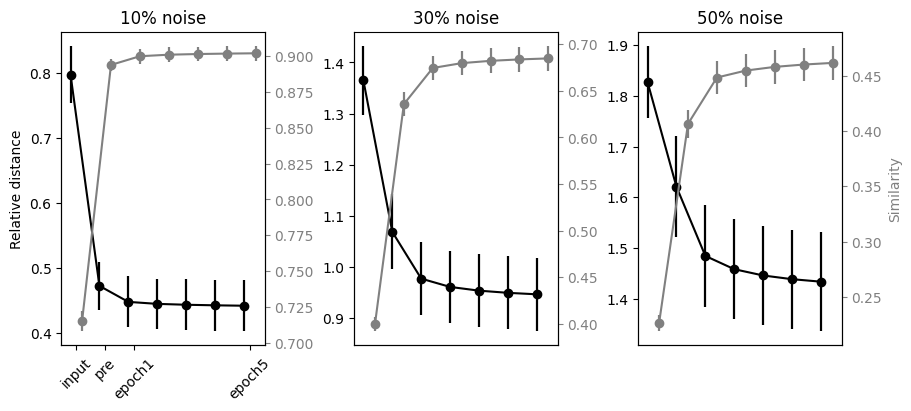

In [13]:
# for different nl trained together
ddc = compute_ddc(dis, ref)  # day, nl, np, img
ddc_ff = compute_ddc(np.expand_dims(dis_ff, 0), np.expand_dims(ref_ff, 0))[0]  # 1, nl, np, img
ddc = ddc.mean(-2)
ddc_ff = ddc_ff.mean(-2)

start plotting Similarity and distances


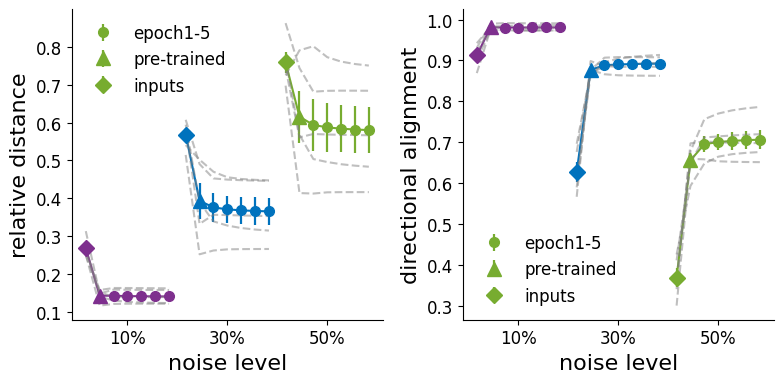

In [33]:
# plot
print('start plotting Similarity and distances')
day_num, nl, n_img = cosine_dist.shape
# labels = ("10%", "30%", "50%")
# labels = ("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
levels = (1, 2, 3)
labels = ("10%", "30%", "50%")
cols = ("#7E2F8E", "#0072BD", "#77AC30")

dodge = 0.2
x_mid = []
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
for n, (i, labels) in enumerate(zip(levels, labels)):
    cds = eff_dist[1:, i]  # day, img
    cds_pre = eff_dist[0, i]  # img
    cds_ff = eff_dist_ff[i]  # img
    # cds = euc_dist[:, i]

    cds2 = cosine_dist[1:, i]  # day, img
    cds2_pre = cosine_dist[0, i]  # img
    cds2_ff = cosine_dist_ff[i]  # img
    
    x = n*(day_num+1) + np.arange(day_num+1) + n*dodge
    x_mid.append((x[0] + x[-1])/2)

    # for j in range(n_img):
    #     cds_s = cds[:, j]  # day
    #     plt.plot(x, cds_s, linestyle='dashed', color='grey', alpha=.6)

    cds_mean = cds.mean(-1)
    cds_sem = sem(cds, -1)
    e1 = axs[0].errorbar(x[2:], cds_mean, yerr=cds_sem, elinewidth=1.6, fmt='o',
                    color=cols[n], markersize=7, label='epoch1-5')
    
    cds_pre_mean = cds_pre.mean()
    cds_pre_sem = sem(cds_pre)
    e2 = axs[0].errorbar(x[1], cds_pre_mean, yerr=cds_pre_sem, elinewidth=1.6, fmt='^',
                    color=cols[n], markersize=10, label='pre-trained')

    cds_ff_mean = cds_ff.mean()
    cds_ff_sem = sem(cds_ff)
    e3 = axs[0].errorbar(x[0], cds_ff_mean, yerr=cds_ff_sem, elinewidth=1.6, fmt='D',
                    color=cols[n], markersize=8, label='inputs')
    
    cds_mean_all = [cds_ff_mean, cds_pre_mean] + list(cds_mean)
    axs[0].plot(x, cds_mean_all, color=cols[n])

    cds2_mean = cds2.mean(-1)
    cds2_sem = sem(cds2, -1)
    f1 = axs[1].errorbar(x[2:], cds2_mean, yerr=cds2_sem, elinewidth=1.6, fmt='o',
                  color=cols[n], markersize=7, label='epoch1-5')
    
    cds2_pre_mean = cds2_pre.mean()
    cds2_pre_sem = sem(cds2_pre)
    f2 = axs[1].errorbar(x[1], cds2_pre_mean, yerr=cds2_pre_sem, elinewidth=1.6, fmt='^',
                  color=cols[n], markersize=10, label='pre-trained')

    cds2_ff_mean = cds2_ff.mean()
    cds2_ff_sem = sem(cds2_ff)
    f3 = axs[1].errorbar(x[0], cds2_ff_mean, yerr=cds2_ff_sem, elinewidth=1.6, fmt='D',
                  color=cols[n], markersize=8, label='inputs')
    
    cds2_mean_all = [cds2_ff_mean, cds2_pre_mean] + list(cds2_mean)
    axs[1].plot(x, cds2_mean_all, color=cols[n])

    if n == 2:
        handle1 = [e1, e2, e3]
        handle2 = [f1, f2, f3]

    for j in range(n_img):
        cds1_single = [cds_ff[j], cds_pre[j]] + list(cds[:, j])
        cds2_single = [cds2_ff[j], cds2_pre[j]] + list(cds2[:, j])
        axs[0].plot(x, cds1_single, '--', color='grey', alpha=.5)
        axs[1].plot(x, cds2_single, '--', color='grey', alpha=.5)

axs[0].set_xticks(x_mid, ['10%', '30%', '50%'])
axs[0].set(ylabel="relative distance")
axs[0].set(xlabel="noise level")
axs[1].set_xticks(x_mid, ['10%', '30%', '50%'])
axs[1].set(ylabel="directional alignment")
axs[1].set(xlabel="noise level")
    
# axs[n].tick_params(axis='y', colors='black')
# axs[n].tick_params(axis='x', rotation=45)

axs[0].spines.right.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)

axs[0].legend(handles=handle1, frameon=False)
axs[1].legend(handles=handle2, frameon=False)

# plt.savefig('met.png')

In [ ]:
# for different nl trained separately
# n2c = []
# for dis, ref in zip(dis_all, ref_all):
#     n2c.append(n2c_precision(dis, ref))
# n2c = np.concatenate(n2c, axis=1)

# _, p = ttest_rel(eff_dist_novel, eff_dist_d2, axis=-1, alternative='greater')

day_num, nl, n_img = ddc.shape
# labels = ("10%", "30%", "50%")
# labels = ("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
levels = (1, 2, 3)
labels = ("10%", "30%", "50%")

# box_width = 0.2
# for i in range(day_num):
#     bplot = plt.boxplot(eff_dist[i].T, positions=2*np.arange(eff_dist.shape[1])-(2*day_num-1-2*i)*box_width/2, widths=box_width, patch_artist=True, showmeans=True)
#     for patch in bplot['boxes']:
#         patch.set_facecolor(plt.cm.magma_r(i/day_num))

dodge = 0.2
fig, axs = plt.subplots(1, len(levels), constrained_layout=True, figsize=(3*len(levels), 4), sharey=False)
for n, (i, labels) in enumerate(zip(levels, labels)):
    cds = ddc[1:, i]
    cds_pre = ddc[0, i]
    cds_ff = ddc_ff[i]
    # cds = euc_dist[:, i]

    cds2 = cosine_dist[1:, i]
    cds2_pre = cosine_dist[0, i]
    cds2_ff = cosine_dist_ff[i]
    
    x = np.arange(day_num+1)

    # for j in range(n_img):
    #     cds_s = cds[:, j]  # day
    #     plt.plot(x, cds_s, linestyle='dashed', color='grey', alpha=.6)

    cds_mean = cds.mean(-1)
    cds_sem = sem(cds, -1)
    axs[n].errorbar(x[2:]-dodge, cds_mean, yerr=cds_sem, elinewidth=1.6, fmt='o',
                    color='black', label='trained')
    
    cds_pre_mean = cds_pre.mean()
    cds_pre_sem = sem(cds_pre)
    axs[n].errorbar(x[1]-dodge, cds_pre_mean, yerr=cds_pre_sem, elinewidth=1.6, fmt='o',
                    color='black', label='pre-trained')

    cds_ff_mean = cds_ff.mean()
    cds_ff_sem = sem(cds_ff)
    axs[n].errorbar(x[0]-dodge, cds_ff_mean, yerr=cds_ff_sem, elinewidth=1.6, fmt='o',
                    color='black', label='inputs')
    
    cds_mean_all = [cds_ff_mean, cds_pre_mean] + list(cds_mean)
    axs[n].plot(x-dodge, cds_mean_all, color='black')
    
    twin = axs[n].twinx()
    # twin.set(ylim=(0.1, 1.0))
    # axs[n].set(xlabel="Epochs", ylabel="Relative distance")
    # twin.set(ylabel="Similarity")

    cds2_mean = cds2.mean(-1)
    cds2_sem = sem(cds2, -1)
    twin.errorbar(x[2:]+dodge, cds2_mean, yerr=cds2_sem, elinewidth=1.6, fmt='o',
                  color='grey', label='trained')
    
    cds2_pre_mean = cds2_pre.mean()
    cds2_pre_sem = sem(cds2_pre)
    twin.errorbar(x[1]+dodge, cds2_pre_mean, yerr=cds2_pre_sem, elinewidth=1.6, fmt='o',
                  color='grey', label='pre-trained')

    cds2_ff_mean = cds2_ff.mean()
    cds2_ff_sem = sem(cds2_ff)
    twin.errorbar(x[0]+dodge, cds2_ff_mean, yerr=cds2_ff_sem, elinewidth=1.6, fmt='o',
                  color='grey', label='inputs')
    
    cds2_mean_all = [cds2_ff_mean, cds2_pre_mean] + list(cds2_mean)
    twin.plot(x+dodge, cds2_mean_all, color='grey')

    if n == 0:
        axs[n].set_xticks([x[0], x[1], x[2], x[-1]], ['input', 'pre', 'epoch1', 'epoch5'])
        axs[n].set(ylabel="Relative distance")
        axs[n].yaxis.label.set_color('black')
    else:
        axs[n].set_xticks([], [])
    
    if n == 2:
        twin.set(ylabel="Similarity")
        twin.yaxis.label.set_color('grey')
    
    axs[n].tick_params(axis='y', colors='black')
    axs[n].tick_params(axis='x', rotation=45)
    twin.tick_params(axis='y', colors='grey')
    
    axs[n].set_title(f'{labels} noise')
    
    # axs[n].spines.right.set_visible(False)
    axs[n].spines.top.set_visible(False)

    # axs[n].legend(frameon=False, loc='right')

    # cds_mean = cds.mean(-1)
    # cds_sem = sem(cds, -1)
    # plt.errorbar(x, cds_mean, yerr=cds_sem, elinewidth=1.6, fmt='-o', 
    #              color=plt.cm.inferno_r(i/nl), label=labels)

# for x in range(10):
#     plt.plot([x-0.15, x-0.15, x+0.15, x+0.15], [1.01, 1.01+0.02, 1.01+0.02, 1.01], color='black')
#     t = '*' if p[x] < 0.05 else 'ns'
#     plt.text(x, 1.01+0.02, f"{t}", ha='center', va='bottom', color='k')

# fig.supxlabel('epochs')
# fig.supylabel('Relative distance', ha='center')
# plt.legend(loc='right', frameon=False)

#### Expansion direction

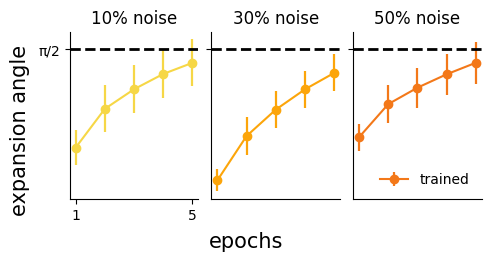

In [21]:
# expansion direction
day_num, nl, imgs, _ = v.shape
v_stim = v[[0], :-1] - v[[0], 1:]  # 1, nl-1, img, pc
v_stim = np.concatenate([v_stim[:, [0]], v_stim], 1)  # 1, nl, img, pc
v_expansion = (v[1:] - v[[0]])  # day-1, nl, img, pc

cos_expansion = np.sum(v_stim*v_expansion, axis=-1)/(norm(v_stim, axis=-1)*norm(v_expansion, axis=-1))  # day-1, nl, img
angle_expansion = np.arccos(np.clip(cos_expansion, -1, 1))  # day-1, nl, img

day_num, nl, n_img = angle_expansion.shape
# labels = ("10%", "30%", "50%")
# labels = ("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
levels = (1, 2, 3)
labels = ("10%", "30%", "50%")

# width = 0.2
# for i in range(day_num-1):
#     plt.errorbar(2*np.arange(angle_expansion.shape[1])-(day_num-2-i)*width, angle_expansion[i].mean(-1), yerr=sem(angle_expansion[i], -1), 
#                  color=plt.cm.magma_r(i/day_num), linewidth=1.5, fmt='-o', alpha=.5)
# # plt.axhline(y=90, linestyle='dashed')

fig, axs = plt.subplots(1, len(levels), constrained_layout=True, figsize=(1.6*len(levels), 2.5), sharey=True)
for n, (i, labels) in enumerate(zip(levels, labels)):
    cds = angle_expansion[:, i]
    # cds = euc_dist[:, i]
    
    x = np.arange(day_num)

    # for j in range(n_img):
    #     cds_s = cds[:, j]  # day
    #     plt.plot(x, cds_s, linestyle='dashed', color='grey', alpha=.6)

    cds_mean = cds.mean(-1)
    cds_sem = sem(cds, -1)
    axs[n].errorbar(x, cds_mean, yerr=cds_sem, elinewidth=1.6, fmt='-o', 
                 color=plt.cm.inferno_r(i/nl), label='trained')
    axs[n].axhline(y=np.pi/2, linestyle='dashed', linewidth=2, color='k')

    if n == 0:
        axs[n].set_xticks([x[0], x[-1]], [1, 5])
        axs[n].set_yticks([0, np.pi/2], ['0', 'π/2'])
    else:
        axs[n].set_xticks([], [])
    
    axs[n].set_title(f'{labels} noise')
    
    axs[n].spines.right.set_visible(False)
    axs[n].spines.top.set_visible(False)

    # cds_mean = cds.mean(-1)
    # cds_sem = sem(cds, -1)
    # plt.errorbar(x, cds_mean, yerr=cds_sem, elinewidth=1.6, fmt='-o', 
    #              color=plt.cm.inferno_r(i/nl), label=labels)

# for x in range(10):
#     plt.plot([x-0.15, x-0.15, x+0.15, x+0.15], [1.01, 1.01+0.02, 1.01+0.02, 1.01], color='black')
#     t = '*' if p[x] < 0.05 else 'ns'
#     plt.text(x, 1.01+0.02, f"{t}", ha='center', va='bottom', color='k')

fig.supxlabel('epochs', fontsize=15)
fig.supylabel('expansion angle', fontsize=15)
plt.legend(frameon=False, loc='lower right')